# Objective
The objetive of this notebook is to replicate example of section 12.5 https://otexts.com/fpp3/bootstrap.html.

# Description of the data
The dataset is quaterly cement production data. As mentioned in the book, the series is relatively long so we will divide the data into train and test.

# Imports, configuration and constants

In [1]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from os import path
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [30]:
sm.__version__, pd.__version__, np.__version__


('0.14.0', '2.0.3', '1.25.0')

In [2]:
PLOT_TITLE = "AUS cement production"
PLOT_YLABEL = "Cement"
PLOT_XLABEL = "Quarter"

# Functions

In [25]:
def plot_cement_df(df: pd.DataFrame, start_time: str=None, end_time: str=None):
    
    df = df.copy()
    
    if start_time is not None:
        df = df.query('date >= @start_time')
    if end_time is not None:
        df = df.query('date <= @end_time')
        
    x = df.date
    y = df.cement
    
    plt.plot(x, y)
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    
    
def plot_cement_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
):
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]
        
    if end_time is not None:
        ts = ts[ts.index <= end_time]
    
    x = ts.index
    y = ts
    
    plt.plot(x, y)
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    
    plt.show()
    
    
def plot_cement_ts_list(
    ts: pd.Series,
    ts_list: list[pd.Series],
    start_time: str = None,
    end_time: str = None,
):
    fig, ax = plt.subplots()
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]

    if end_time is not None:
        ts = ts[ts.index <= end_time]
    
    x = ts.index
    y = ts
    ax.plot(x, y, color="black")
    
    for ts in ts_list:
        if start_time is not None:
            ts = ts[ts.index >= start_time]

        if end_time is not None:
            ts = ts[ts.index <= end_time]

        x = ts.index
        y = ts
        ax.plot(x, y, alpha=0.5)

    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)

    plt.show()
    
    
def get_wrapped_indexes(start_index: int, end_index: int, series_length: int) -> list[int]:
    if start_index <= end_index:
        indexes = list(range(start_index, end_index))
    else:
        indexes = list(range(start_index, series_length)) + list(range(0, end_index))
    return indexes


def _blocked_bootstrap_remainder(
    remainder: pd.Series,
    series_length: int,
    bootstrap_block_size: int,
    n_whole_blocks: int,
    n_remaining_indexes: int
) -> np.array:
    
    start_index = np.random.randint(series_length)
    
    block_indexes_list = list()
    for _ in range(n_whole_blocks):
        end_index = (start_index + bootstrap_block_size) % series_length
        block_indexes = get_wrapped_indexes(start_index, end_index, series_length)
        block_indexes_list.append(block_indexes)

        start_index = end_index

    if n_remaining_indexes > 0:
        end_index = (start_index + n_remaining_indexes) % series_length
        remaining_indexes = get_wrapped_indexes(start_index, end_index, series_length)
        block_indexes_list.append(remaining_indexes)
    
    random.shuffle(block_indexes_list)
    
    bootstrapped_remainder_indexes = np.concatenate(block_indexes_list)
    bootstrapped_remainder_ts = remainder[bootstrapped_remainder_indexes]
    bootstrapped_remainder_arr = np.array(bootstrapped_remainder_ts)
    
    return bootstrapped_remainder_arr
    

def blocked_bootstrap(
    ts: pd.Series, 
    times: int, 
    bootstrap_block_size: int = 8,
) -> list[pd.Series]:
    
    series_length = len(ts)
    
    # Computing block size information
    n_whole_blocks = series_length // bootstrap_block_size
    n_remaining_indexes = series_length % bootstrap_block_size
    
    # Decompose the transformed series into trend, seasonal, and remainder components using STL
    decomposition = STL(ts).fit()
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    remainder = decomposition.resid
    
    start_index = np.random.randint(series_length)
    
    boostrapped_ts_list = list()
    for _ in range(times):
        bootstrapped_remainder_arr = _blocked_bootstrap_remainder(
            remainder,
            series_length,
            bootstrap_block_size,
            n_whole_blocks,
            n_remaining_indexes,
        )
        
        bootstrapped_ts = trend + seasonal + bootstrapped_remainder_arr
        boostrapped_ts_list.append(bootstrapped_ts)
    
    # Return the bootstrapped series
    return boostrapped_ts_list


def ets_forecast_ts(ts: pd.Series, model_config=dict) -> tuple[pd.Series, pd.Series, pd.Series]:
    model = ETSModel(ts, **model_config)
    
    fit = model.fit(disp=0)
    pred = fit.get_prediction(
        start=ts_test.index[0], 
        end=ts_test.index[-1],
    )
    df_pred = pred.summary_frame(alpha=0.05)
    
    ts_h = pd.Series(
        df_pred['mean'].values, 
        index=df_pred.index,
    )
    
    ts_h_lower = pd.Series(
        df_pred['pi_lower'].values, 
        index=df_pred.index,
    )

    ts_h_upper = pd.Series(
        df_pred['pi_upper'].values, 
        index=df_pred.index,
    )
    
    return ts_h, ts_h_lower, ts_h_upper


def _average_forecast_list(ts_list: list[pd.Series]):
    
    df = pd.concat(ts_list, axis=1)
    ts_avg = df.mean(axis=1)
    
    return ts_avg


def average_forecast(
    ts_h_list: list[pd.Series], 
    ts_h_lower_list: list[pd.Series], 
    ts_h_upper_list: list[pd.Series]
) -> tuple[pd.Series, pd.Series, pd.Series]: 
    
    ts_h_avg = _average_forecast_list(ts_h_list)
    ts_h_lower_avg = _average_forecast_list(ts_h_lower_list)
    ts_h_upper_avg = _average_forecast_list(ts_h_upper_list)
    
    return ts_h_avg, ts_h_lower_avg, ts_h_upper_avg
    
    
def bagged_ets_forecasts(boostrapped_ts_list: list[pd.Series], model_config=dict):
    ts_h_list = list()
    ts_h_lower_list = list()
    ts_h_upper_list = list()
    
    for boostrapped_ts in boostrapped_ts_list:
        ts_h, ts_h_lower, ts_h_upper = ets_forecast_ts(boostrapped_ts, model_config)
        ts_h_list.append(ts_h)
        ts_h_lower_list.append(ts_h_lower)
        ts_h_upper_list.append(ts_h_upper)
        
    ts_h_avg, ts_h_lower_avg, ts_h_upper_avg = average_forecast(
        ts_h_list,
        ts_h_lower_list,
        ts_h_upper_list,
    )
    
    return ts_h_avg, ts_h_lower_avg, ts_h_upper_avg

# Load data

In [4]:
data_dir_path = "../data-raw/"
aus_production_path = path.join(data_dir_path, "aus_production.csv")

df = pd.read_csv(aus_production_path, sep='|')
df.columns = df.columns.str.lower()

# Prepare data
Filter the data as done in the book.

In [5]:
df = df.rename(columns={"quarter": "year_quarter"})

# Split the 'year_quarter' column into separate 'year' and 'quarter' columns
df[['year', 'quarter']] = df['year_quarter'].str.split(' Q', expand=True)

# Combine the 'year' and 'quarter' columns into a datetime column
df['date'] = (
    pd.PeriodIndex(
        year=df['year'].astype(int), 
        quarter=df['quarter'].astype(int)
    ).to_timestamp()
)

df = df[["cement", "date"]]
df = df[df.date >= "1988-01-01"]

df.head()

,cement,date
128,1418,1988-01-01
129,1625,1988-04-01
130,1770,1988-07-01
131,1791,1988-10-01
132,1621,1989-01-01


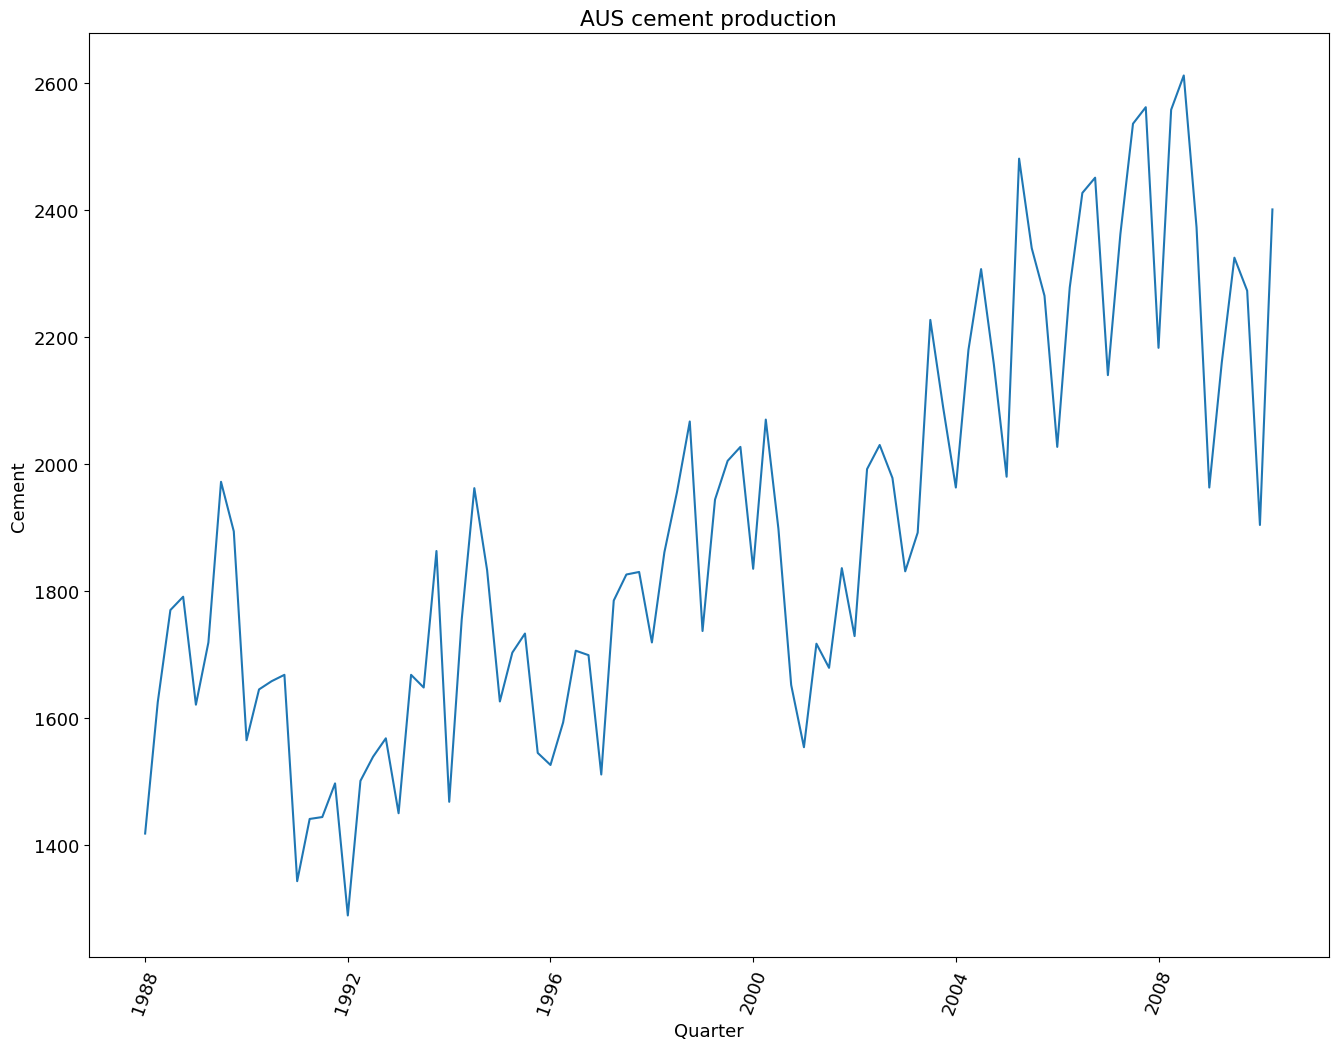

In [6]:
plot_cement_df(df, start_time=1988)

In [7]:
ts = pd.Series(df.cement.values, index=df.date)
ts.head()

date
1988-01-01    1418
1988-04-01    1625
1988-07-01    1770
1988-10-01    1791
1989-01-01    1621
dtype: int64

# Bootstrapping time series

In [14]:
boostrapped_ts_list = blocked_bootstrap(ts, 10)

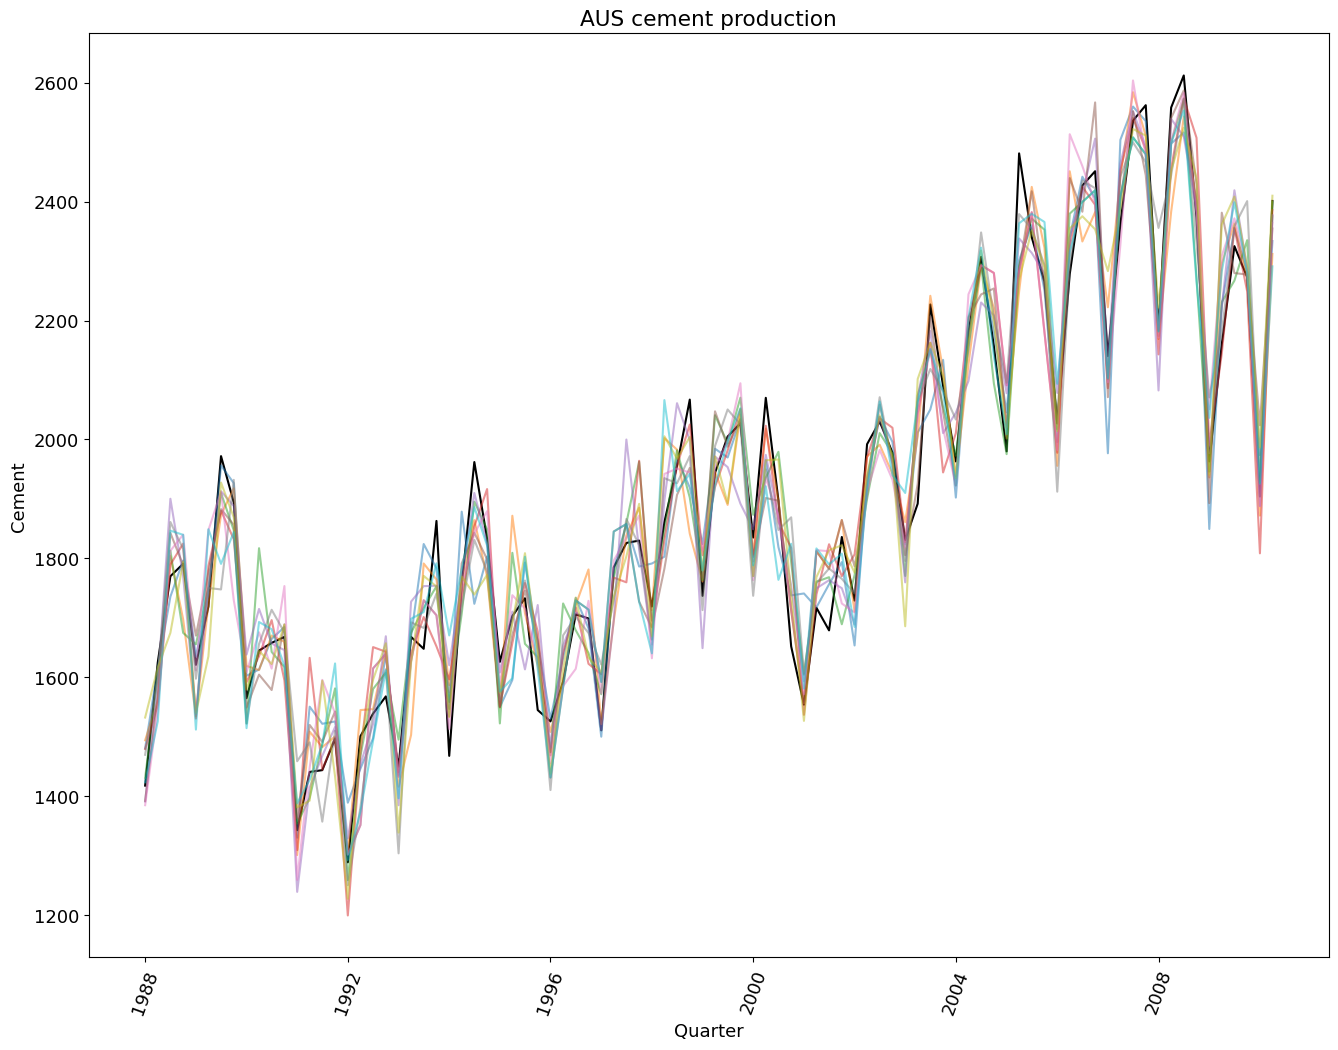

In [15]:
plot_cement_ts_list(ts, boostrapped_ts_list)

# Bagged forecast
In the chapter they automatically fit a ETS model to each of the boostrapped series. In statsmodels there is no option to automatically fit the model. What we did in example 12_2, where we already forecasted this series with a ETS model, was to copy the model that the book obtained by autofitting it. We are going to do the same thing. 

Also, even though in this chapter they don't split the series into train and test, we are going to split them here to see if this boostrapping alternative improves the results.

In [20]:
date_split = "2007-01-01"

# Adding frecuency information to avoid statsmodels frecuency warning
ts.index = pd.date_range(start=ts.index[0], periods=len(ts), freq='QS-OCT')

ts_train = ts[ts.index <= date_split]
ts_test = ts[ts.index > date_split]

In [21]:
boostrapped_ts_list = blocked_bootstrap(ts_train, 100)

Forecasting the series with both methods.

In [26]:
model_config = dict(error="mul", trend=None, seasonal="mul")

ts_h_avg, ts_h_lower_avg, ts_h_upper_avg = bagged_ets_forecasts(
    boostrapped_ts_list, 
    model_config,
)

ts_h, ts_h_lower, ts_h_upper = ets_forecast_ts(ts_train, model_config)

In [27]:
labels = ["single", "bagged"]

ts_hs = [ts_h, ts_h_avg]
ts_hs_lower = [ts_h_lower, ts_h_lower_avg]
ts_hs_upper = [ts_h_upper, ts_h_upper_avg]

As explained in the character on average using bagging gives better forecasts than applying ETS directly and that is the case for this example.

In [28]:
metrics_list = list()
for i in range(len(ts_hs)):
    metrics = dict(
        model=labels[i],
        rmse=mean_squared_error(ts_test, ts_hs[i], squared=False),
        mae=mean_absolute_error(ts_test, ts_hs[i]),
        mape=mean_absolute_percentage_error(ts_test, ts_hs[i]),
    )
    
    metrics_list.append(metrics)
    
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,model,rmse,mae,mape
0,single,142.696010,123.163019,0.054726
1,bagged,141.719136,121.458122,0.053808
